In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os

In [2]:
Fs = 500
T = 20
#Create csv file for 20 seconds of data

AD_EEG_Data = pd.read_csv(os.path.join("EEG_human","ad_eeg_20.csv"))
AD_EEG_Data = AD_EEG_Data[AD_EEG_Data['time'] <= T]
#AD_EEG_Data.to_csv(os.path.join('EEG_human', 'ad_eeg_300.csv'))

Control_EEG_Data = pd.read_csv(os.path.join("EEG_human","control_eeg_20.csv"))
Control_EEG_Data = Control_EEG_Data[Control_EEG_Data['time'] <= T]
#Control_EEG_Data.to_csv(os.path.join('EEG_human', 'control_eeg_300.csv'))

ftd_EEG_Data = pd.read_csv(os.path.join("EEG_human","ftd_eeg_20.csv"))
ftd_EEG_Data = ftd_EEG_Data[ftd_EEG_Data['time'] <= T]
#ftd_EEG_Data.to_csv(os.path.join('EEG_human', 'ftd_eeg_300.csv'))


In [3]:
#Not using Hanning Window

window = np.hanning(AD_EEG_Data.shape[0])
columns_to_window = [
    col for col in AD_EEG_Data.columns
    if col not in ["Unnamed: 0", "time"]
]
#AD_EEG_Data[columns_to_window] = AD_EEG_Data[columns_to_window].mul(window, axis=0)

In [4]:
def time_to_fft_welch(df, Fs=500):
    freqs = np.fft.fftfreq(df.shape[0], 1/Fs)
    fft_df = pd.DataFrame({'freq': list(filter(lambda x: x > 0, freqs))})

    def pandas_fft(x):
        temp_fft = np.fft.fft(x).real
        temp_fft = temp_fft[:len(temp_fft)//2]
        return temp_fft

    fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
    return list(filter(lambda x: x > 0, freqs)), fft_df

In [5]:
def time_to_fft(df, Fs=500):
    freqs = np.fft.fftfreq(df.shape[0], 1/Fs)
    fft_df = pd.DataFrame({'freq': list(filter(lambda x: x > 0, freqs))})

    def pandas_fft(x):
        temp_fft = np.fft.fft(x)
        temp_fft = temp_fft[:len(temp_fft)//2]
        temp_fft = np.abs(temp_fft)**2
        return temp_fft

    fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
    return list(filter(lambda x: x > 0, freqs)), fft_df

In [6]:
column_suffix = ["Fp1", "Fp2", "F3"]
ad_row_means = {}
control_row_means = {}
welch_ad_row_means = {}
welch_control_row_means = {}


AD_freqs, AD_EEG_FFT_df = time_to_fft(AD_EEG_Data)
Control_freqs, Control_EEG_FFT_df = time_to_fft(Control_EEG_Data)

welch_AD_freqs, welch_AD_EEG_FFT_df = time_to_fft_welch(AD_EEG_Data)
welch_Control_freqs, welch_Control_EEG_FFT_df = time_to_fft_welch(Control_EEG_Data)

for suffix in column_suffix:
    ad_row_means[f'mean_{suffix}'] = AD_EEG_FFT_df.filter(like=f'-{suffix}').mean(axis=1)
    control_row_means[f'mean_{suffix}'] = Control_EEG_FFT_df.filter(like=f'-{suffix}').mean(axis=1)
    welch_ad_row_means[f'mean_{suffix}'] = welch_AD_EEG_FFT_df.filter(like=f'-{suffix}').mean(axis=1)
    welch_control_row_means[f'mean_{suffix}'] = welch_Control_EEG_FFT_df.filter(like=f'-{suffix}').mean(axis=1)


averaged_AD_EEG_FFT_df = pd.DataFrame(ad_row_means)
averaged_Control_EEG_FFT_df = pd.DataFrame(control_row_means)
welch_averaged_AD_EEG_FFT_df = pd.DataFrame(welch_ad_row_means)
welch_averaged_Control_EEG_FFT_df = pd.DataFrame(welch_control_row_means)

C:\Users\ethan\AppData\Local\Temp\ipykernel_32656\462758267.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\ethan\AppData\Local\Temp\ipykernel_32656\534297713.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)


# Control

(0.0, 45.0)

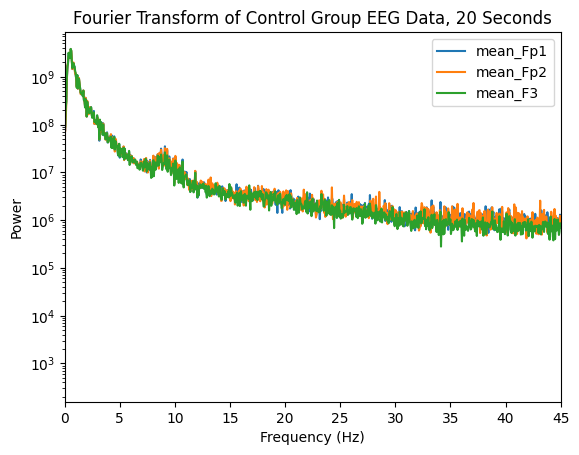

In [ ]:
for column in averaged_Control_EEG_FFT_df.columns:
    plt.plot(Control_freqs, averaged_Control_EEG_FFT_df[column], label=column)

plt.title("Fourier Transform of Control Group EEG Data, 20 Seconds")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.yscale('log')
plt.xlim(0,45)

#Should make another plot showing the whole frequency range to demonstrate the butterworth band-pass filter done in preprocessing

# Alzheimers

(0.0, 45.0)

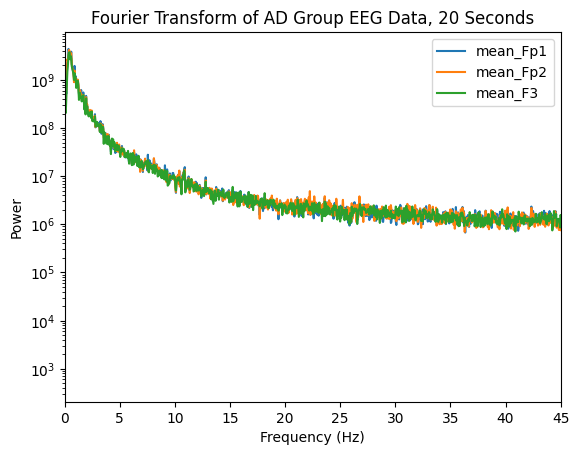

In [8]:
for column in averaged_AD_EEG_FFT_df.columns:
    plt.plot(AD_freqs, averaged_AD_EEG_FFT_df[column], label=column)

plt.title("Fourier Transform of AD Group EEG Data, 20 Seconds")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.yscale('log')
plt.xlim(0,45)

(0.0, 45.0)

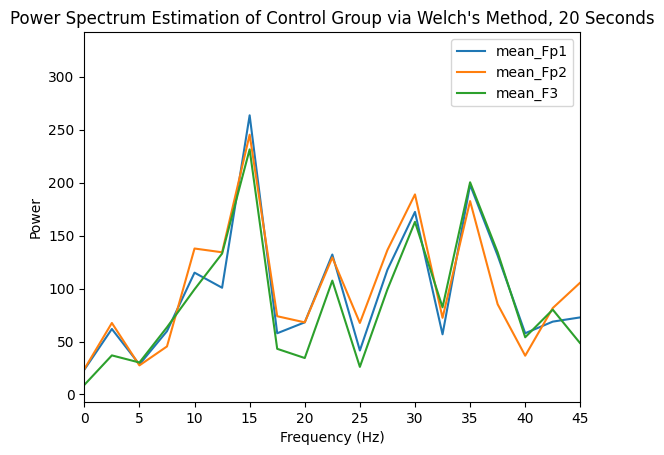

In [9]:
for column in averaged_Control_EEG_FFT_df.columns:
    f, Pxx = sp.signal.welch(welch_averaged_Control_EEG_FFT_df[column], fs = Fs, nperseg = 200)
    plt.plot(f, Pxx, label=column)

plt.title("Power Spectrum Estimation of Control Group via Welch's Method, 20 Seconds")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.xlim(0,45)

(0.0, 45.0)

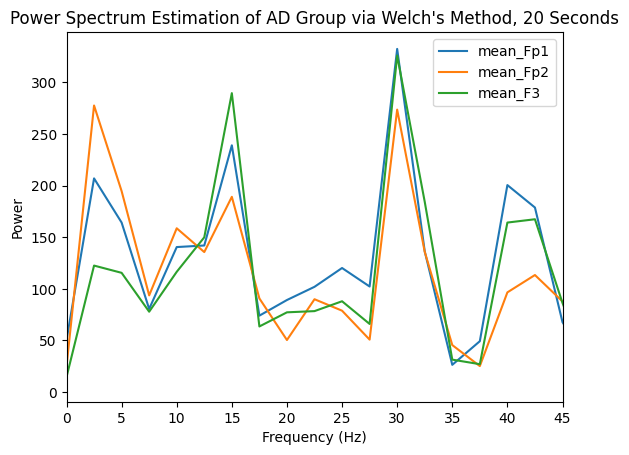

In [10]:
for column in averaged_AD_EEG_FFT_df.columns:
    f, Pxx = sp.signal.welch(welch_averaged_AD_EEG_FFT_df[column], fs = Fs, nperseg = 200)
    plt.plot(f, Pxx, label=column)

plt.title("Power Spectrum Estimation of AD Group via Welch's Method, 20 Seconds")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.xlim(0,45)